In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from tensorflow import keras

from dataset_no_context import DataGen
from models.MaskGenerator_No_Context import MaskGenerator
from models.UNETO_CELTIC import UNet3D
from models.fnet_model import CELTICModel
from transforms import normalize, normalize_with_mask, Propper


2025-08-13 11:45:55.012708: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
class Wrapper(nn.Module):
    def __init__(self, celtic_model):
        super().__init__()
        self.model = celtic_model
        self.model.net.eval()
        for param in self.model.net.parameters():
            param.requires_grad = False  # Freeze weights

    def forward(self, signal: torch.Tensor, m = None):
        pred = self.model.net(signal)
        pred = pred * m
        return pred


In [3]:
all_organelles = ["Nucleolus-(Granular-Component)", "Nuclear-envelope", "Mitochondria", "Actin-filaments",
                 "Endoplasmic-reticulum", "Plasma-membrane", "Microtubules"]

In [4]:
# Define base path for all operations
BASE_PATH = f'/{"/".join(os.getcwd().split("/")[1:-1])}'
RESOURCES_PATH = BASE_PATH + "/resources/resources"
print(BASE_PATH)
print(RESOURCES_PATH)

'/mnt/new_home/gadmicha'

In [5]:
# --- Configuration ---
CONTINUE_TRAINING = True
weighted_pcc = False
signals_are_masked = True
organelle = all_organelles[1]
organelle_path = organelle.lower()

unet_model_path = f"{RESOURCES_PATH}/{organelle}/models/best_model_no_context.p"
mg_model_path = f"{BASE_PATH}/mg/No_Context/{organelle}/model_mw_0.9_lr_1e-05_pcc_0.89_noise_1.0.pt"
data_path = f"/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_processed/cells/source/"
test_csv_path = f"{RESOURCES_PATH}/{organelle}/metadata/test_images.csv"
patch_size = (32, 64, 64, 1)


In [6]:
# --- Load context config ---
with open(f"{RESOURCES_PATH}/{organelle}/models/context_model_config.json", 'r') as file:
    context_model_config = json.load(file)


In [7]:
transforms_config = context_model_config["transforms"]

# Evaluate each string in the config using `eval`, injecting train_patch_size
transforms = {
    k: eval(v, {"normalize": normalize,
                "normalize_with_mask": normalize_with_mask,
                "Propper": Propper,
                "train_patch_size": patch_size[:-1]})
    for k, v in transforms_config.items()
}

In [8]:
# === Load Datasets ===
test_dataset = DataGen(test_csv_path, data_path, transforms, signals_are_masked)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [9]:
# === Initialize Models ===
unet = UNet3D(in_channels=2, out_channels=1)


In [10]:
%%capture

# --- Load CELTIC model ---
model = CELTICModel(context=None, signals_are_masked=signals_are_masked)
model.load_state(unet_model_path)
model_wrapper = Wrapper(model)

model.net.eval()

# --- Load Mask model ---
mg = MaskGenerator(patch_size, unet, model_wrapper, mask_loss_weight=0.9, weighted_pcc=weighted_pcc,
                   pcc_target=0.89)
mg.load_state_dict(torch.load(mg_model_path))

mg.eval()


In [11]:
%%capture

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.net.to(device)
mg.to(device)

In [12]:
# Check specific cell from csv, TO DELETE
import tifffile as tiff
import inspect

n = 292208
x = tiff.imread(f"/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_processed/cells/source/2030_{n}_signal.tiff").astype(np.float32)
y = tiff.imread(f"/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_processed/cells/source/2030_{n}_target.tiff").astype(np.float32)
m = tiff.imread(f"/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_processed/cells/source/2030_{n}_mask.tiff").astype(np.float32)

# Apply transforms
for t in transforms['signal']:
    if m is not None and 'mask' in inspect.signature(t).parameters:
        x = t(x, m)
    else:
        x = t(x)

for t in transforms['target']:
    if m is not None and 'mask' in inspect.signature(t).parameters:
        y = t(y, m)
    else:
        y = t(y)

if m is not None:
    for t in transforms['mask']:
        m = t(m)

# Convert to torch tensors, shape: (C, D, H, W)
x = torch.tensor(x[np.newaxis, ...])
y = torch.tensor(y[np.newaxis, ...])

# Add batch size and make torch
x = torch.from_numpy(np.expand_dims(x, axis=0))
y = torch.from_numpy(np.expand_dims(y, axis=0))
m = torch.from_numpy(np.expand_dims(m, axis=0))

# Move to device if needed
x, y, m = x.to(device), y.to(device), m.to(device)

# Run through the model
with torch.no_grad():
    prediction = model_wrapper(x, m)

with torch.no_grad():
    x_input = torch.cat([
        F.relu(F.conv3d(x, weight=torch.ones(1, x.shape[1], 3, 3, 3).to(device), padding=1)),
        F.relu(F.conv3d(prediction, weight=torch.ones(1, prediction.shape[1], 3, 3, 3).to(device), padding=1))
    ], dim=1).to(device)


In [13]:
# # To get a specific row in the dataset
# row_number = 5

# # Get images
# x, y, m = test_dataset[row_number]

# # Add batch size and make torch
# x = torch.from_numpy(np.expand_dims(x, axis=0))
# y = torch.from_numpy(np.expand_dims(y, axis=0))
# m = torch.from_numpy(np.expand_dims(m, axis=0))

# # Move to device if needed
# x, y, m = x.to(device), y.to(device), m.to(device)

# # Run through the model
# with torch.no_grad():
#     prediction = model_wrapper(x, m)


In [14]:
with torch.no_grad():
    x_input = torch.cat([
        F.relu(F.conv3d(x, weight=torch.ones(1, x.shape[1], 3, 3, 3).to(device), padding=1)),
        F.relu(F.conv3d(prediction, weight=torch.ones(1, prediction.shape[1], 3, 3, 3).to(device), padding=1))
    ], dim=1).to(device)


In [15]:
mask = mg.mask_net(x_input)


In [16]:
mask.shape


torch.Size([1, 1, 32, 224, 256])

In [17]:
input_patch = x.detach().cpu()
target_patch = y.detach().cpu()
pred = prediction.detach().cpu()
mask_prediction = mask.detach().cpu()


In [18]:
threshold = 0.4
binary_mask = (mask_prediction > threshold).float()

(-0.5, 255.5, 223.5, -0.5)

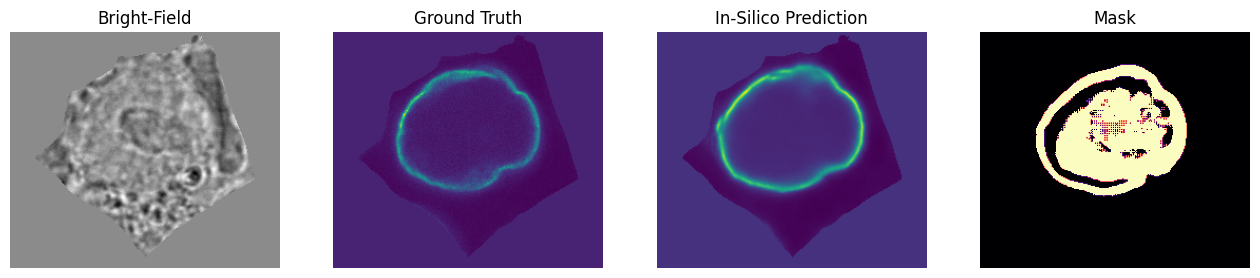

In [19]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
zs = int(mask.shape[2]/2)
ax1.imshow(input_patch[0,0,zs,:,:], cmap='gray')
ax1.set_title('Bright-Field')
ax1.axis('off')
ax2.imshow(target_patch[0,0,zs,:,:], cmap='viridis')
ax2.set_title('Ground Truth')
ax2.axis('off')
ax3.imshow(pred[0,0,zs,:,:], cmap='viridis')
ax3.set_title('In-Silico Prediction')
ax3.axis('off')
ax4.imshow(binary_mask[0,0,zs,:,:], cmap='magma')
ax4.set_title('Mask')
ax4.axis('off')

In [20]:
# Plot different z-stacks to catch true explanation

In [21]:
def plot_slices(image, step=4, cmap="magma"):
    z_slices = image.shape[2]
    selected_slices = range(0, z_slices, step)
    
    # Create subplots dynamically based on the number of slices
    num_slices = len(selected_slices)
    fig, axes = plt.subplots(1, num_slices, figsize=(5 * num_slices, 5))  # Adjust figure size
    
    # Ensure axes is iterable, even for one slice
    if num_slices == 1:
        axes = [axes]
    
    # Loop through and plot every 4th Z-slice
    for i, z in enumerate(selected_slices):
        ax = axes[i]
        ax.imshow(image[0,0,z,:,:], cmap=cmap)
        ax.set_title(f'Z-slice {z}')
        ax.axis('off')  # Turn off axes for cleaner visualization
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

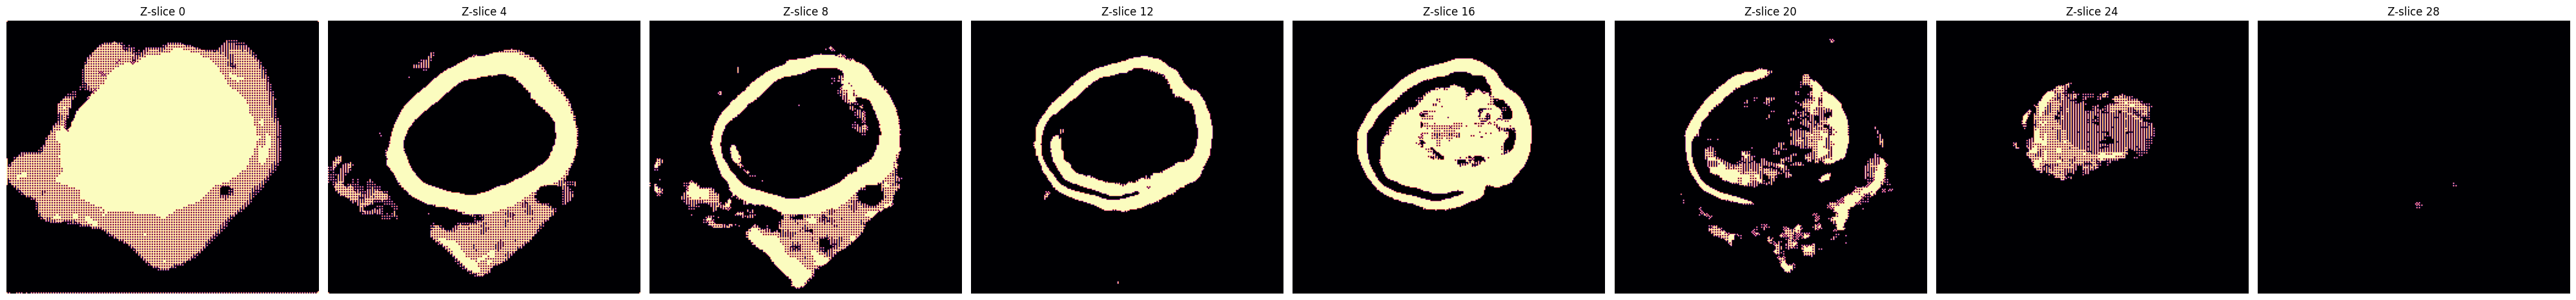

In [22]:
plot_slices(binary_mask)

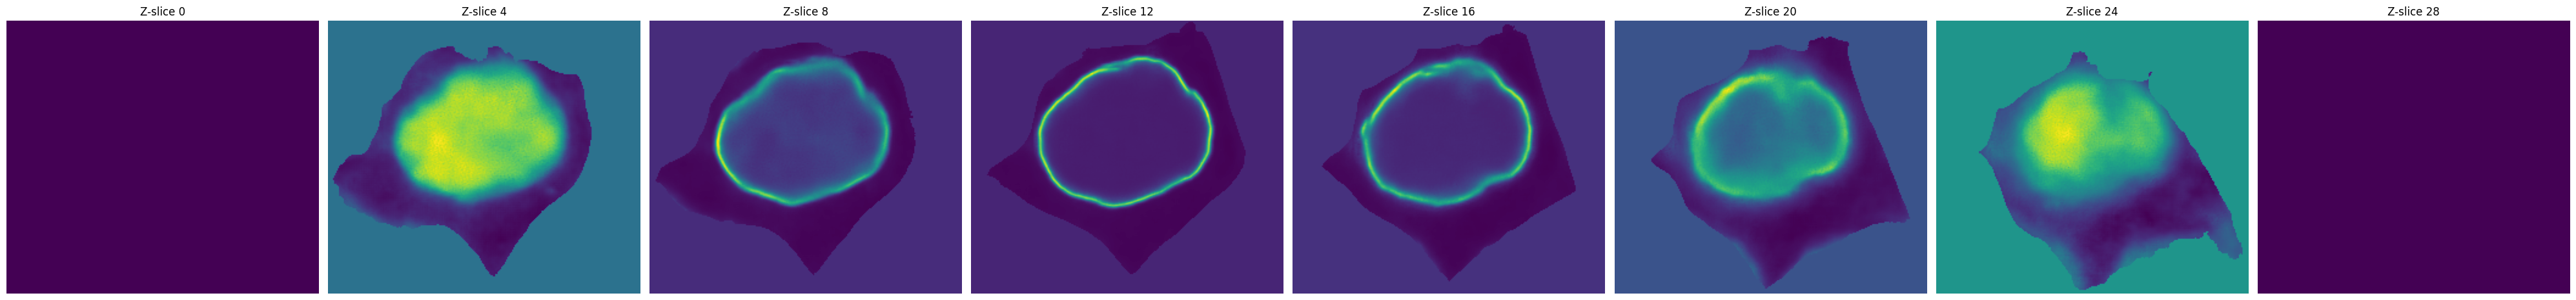

In [23]:
plot_slices(pred, cmap="viridis")

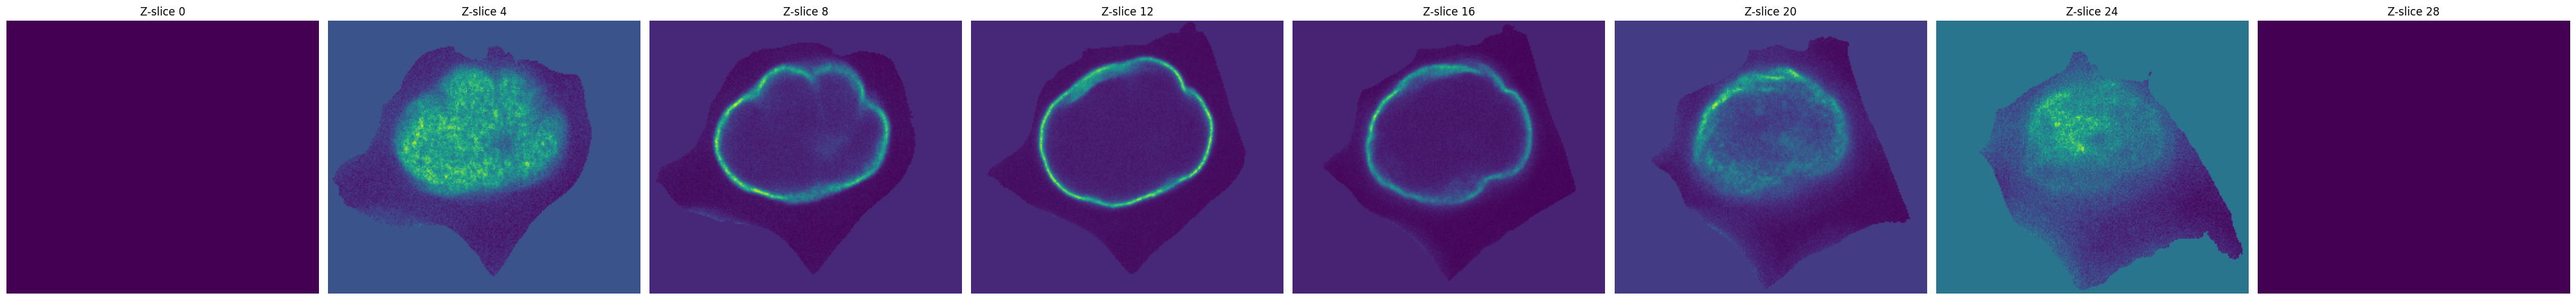

In [24]:
plot_slices(target_patch, cmap="viridis")

## Noise Validation

### Main Version

In [25]:
from scipy.ndimage import label, binary_closing, binary_erosion

In [102]:
def get_manual_noise(seg_gt_image, mask_image):
    # Get predicted mask where there is no segmentation
    false_positives = (mask_image * (1.0 - seg_gt_image)).astype(bool)

    # Label connected components
    labeled_fp, num = label(false_positives)

    # Remove small objects manually (connected components < 100 pixels)
    cleaned_mask = np.zeros_like(false_positives, dtype=bool)
    for i in range(1, num + 1):
        component = (labeled_fp == i)
        if np.sum(component) >= 100:
            cleaned_mask |= component

    return (cleaned_mask.astype(np.uint8)) * 255


def process_mask_image(manual_noise, steps=3):
    """Process the mask image and reduce it in specified steps."""
    # Close holes in the mask
    closed_mask = binary_closing((manual_noise[:, :, :] / 255).astype(np.uint8), structure=np.ones((1,3,3))).astype(int)
    closed_mask = binary_erosion(closed_mask, structure=np.ones((1,7,7))).astype(int)
    # Create stepwise reductions
    step_reductions = []
    for i in range(steps):
        closed_mask = binary_erosion(closed_mask, structure=np.ones((1,11,11))).astype(int)
        step_reductions.append(closed_mask)
    
    return step_reductions


def process_mask_image_soft(manual_noise, steps=3):
    """Process the mask image and reduce it in specified steps."""
    # Close holes in the mask
    closed_mask = binary_closing((manual_noise[:, :, :] / 255).astype(np.uint8), structure=np.ones((1,5,5))).astype(int)
    # closed_mask = binary_erosion(closed_mask, structure=np.ones((1,7,7))).astype(int)
    # Create stepwise reductions
    step_reductions = []
    for i in range(steps):
        closed_mask = binary_erosion(closed_mask, structure=np.ones((1,9,9))).astype(int)
        step_reductions.append(closed_mask)
    
    return step_reductions


def overlay_images(input_image, mask_image, result_image):
    """
    Overlay predicted and ground truth binary masks on a grayscale input image.

    - GT (mask_image) is turquoise
    - Prediction (result_image) is light green
    - Overlap is just additive (no separate color)
    - Input image is dynamically normalized
    """

    # Normalize input to [0, 1] using its own min/max
    min_val, max_val = np.min(input_image), np.max(input_image)
    if max_val > min_val:
        input_image = (input_image - min_val) / (max_val - min_val)
    else:
        input_image = np.zeros_like(input_image, dtype=np.float32)

    # Convert grayscale to RGB
    input_rgb = np.stack([input_image]*3, axis=-1)

    # Define overlay colors
    turquoise = np.array([64, 224, 208]) / 255.0
    light_green = np.array([0, 224, 0]) / 255.0

    # Apply masks
    gt_mask = mask_image > 0
    pred_mask = result_image > 0

    input_rgb[gt_mask] = 0.5 * turquoise + 0.5 * input_rgb[gt_mask]
    input_rgb[pred_mask] = 0.5 * light_green + 0.5 * input_rgb[pred_mask]

    return (input_rgb * 255).astype(np.uint8)


#### FOV Level

In [27]:
# full_metadata = pd.read_csv(f"{BASE_PATH}/Nitsan_New/resources/resources/{organelle}/metadata/full_metadata.csv")

In [28]:
# seg_path = full_metadata[full_metadata["CellId"] == n]["fov_seg_path"].iloc[0]
# seg_path = seg_path.split('/')[1]
# seg_folder = f"/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_seg/"
# seg_path = seg_folder + seg_path
# seg_path

In [29]:
# seg_image = tiff.imread(seg_path)
# seg_gt_image = seg_image[:, 2]

In [507]:
seg_image = tiff.imread("/sise/assafzar-group/assafzar/full_cells_fovs/Nuclear-envelope/Nuclear-envelope_116.tiff")
seg_gt_image = seg_image[6]

In [508]:
seg_gt_image = (seg_gt_image > 0).astype(np.uint8)

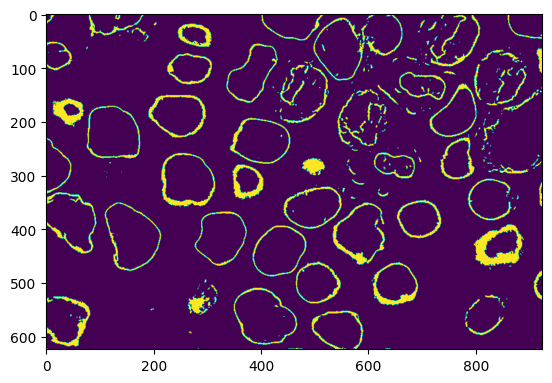

In [509]:
plt.imshow(seg_gt_image[32])

In [510]:
th = 0.2

# TODO-save mask for this image (116) and load here
mask_from_disc = tiff.imread("/mnt/new_home/gadmicha/Regression/Inference/Nuclear-envelope/image_116_inference_outputs.tiff")[1]
mask_with_th = (mask_from_disc > 0).astype(np.uint8)


In [511]:
cleaned_mask_lion = get_manual_noise(seg_gt_image, mask_with_th)

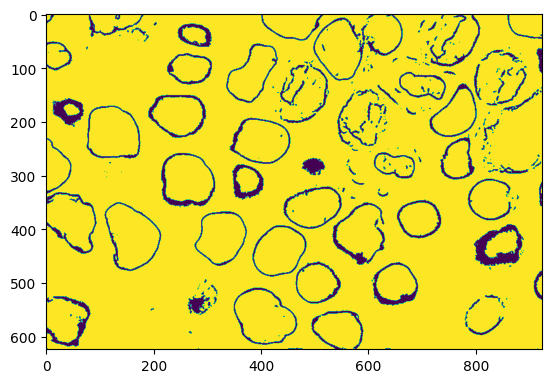

In [512]:
plt.imshow(cleaned_mask_lion[32])

In [447]:
processed_masks_lion = process_mask_image(cleaned_mask_lion)

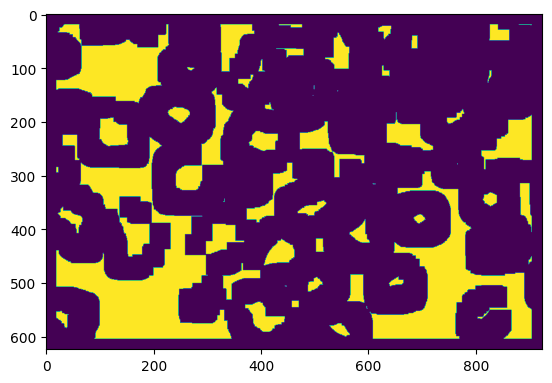

In [448]:
plt.imshow(processed_masks_lion[2][32])

#### Single Cell Level

In [103]:
# Using Nitsan's data (Resize prevents using both datasets together)
threshold = 0.4
binary_mask = (mask_prediction > threshold).float()

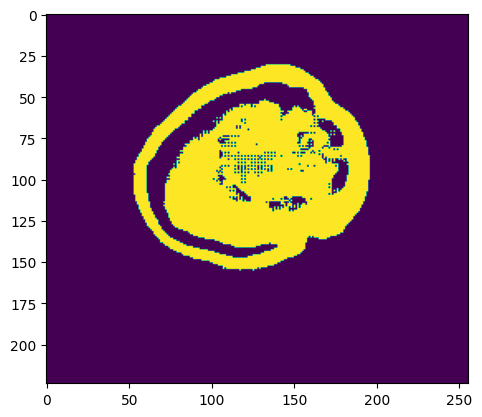

In [104]:
plt.imshow(binary_mask.cpu().numpy()[0,0][16])

In [105]:
cell_seg = (target_patch > 2).float()

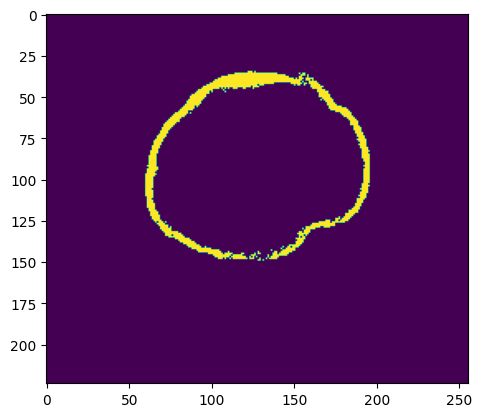

In [106]:
plt.imshow(cell_seg[0,0,16])

In [107]:
cleaned_mask_nitsan = get_manual_noise(cell_seg.cpu().numpy()[0,0], binary_mask.cpu().numpy()[0,0])

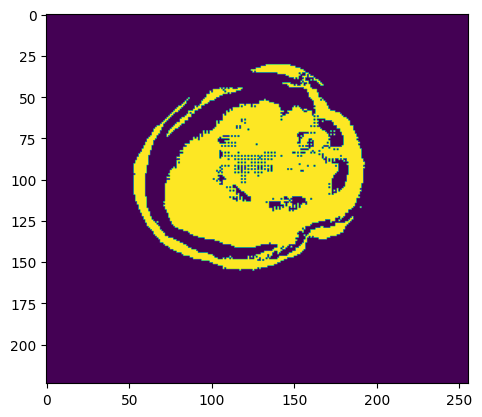

In [108]:
plt.imshow(cleaned_mask_nitsan[16])

In [109]:
processed_masks_nitsan = process_mask_image_soft(cleaned_mask_nitsan)

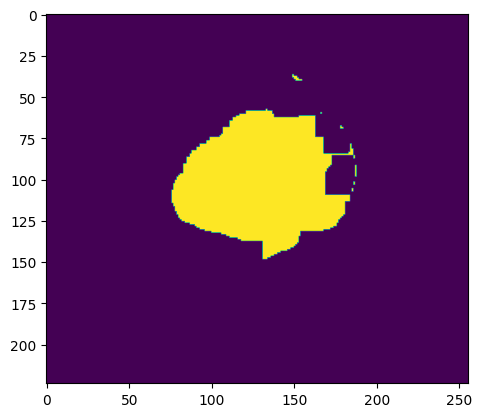

In [120]:
plt.imshow(processed_masks_nitsan[0][16])

In [145]:
index = 2

In [146]:
noise = processed_masks_nitsan[index]

In [147]:
noise_percentage = 100 * np.count_nonzero(noise) / noise.size
print(f"{noise_percentage:.2f}% of the pixels are noise.")

3.71% of the pixels are noise.


In [148]:
noise = np.expand_dims(noise, axis=0)
noise = np.expand_dims(noise, axis=0)

In [149]:
noised_input = input_patch.clone()
noised_input = np.where(noise, noise, noised_input)

In [150]:
z = 16
input_cpu = input_patch.cpu().numpy()[0,0,z]
mask_cpu = binary_mask.cpu().numpy()[0,0,z]
overlay = overlay_images(input_cpu, mask_cpu, noise[0,0,z])

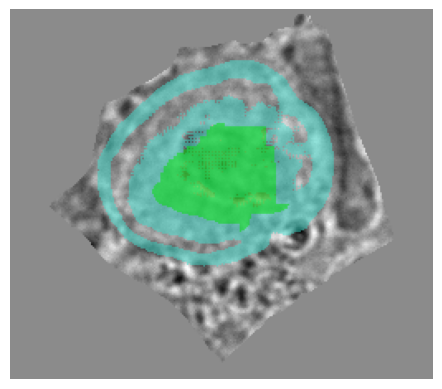

In [151]:
plt.axis('off')
plt.imshow(overlay)

In [152]:
noised_input = torch.from_numpy(noised_input).float().to(device)

### Alternative Version

In [75]:
# Choose mask threshold
threshold = 0.4
binary_mask = (mask_prediction > threshold).float()

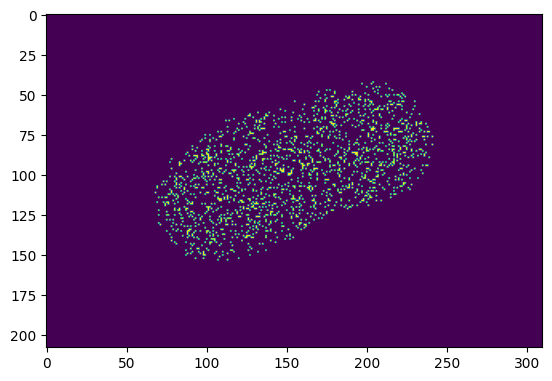

In [74]:
# Noise nuclei

# Using Nitsan's data
# Find image from full metadata
full_metadata = pd.read_csv(f"{BASE_PATH}/Nitsan_New/resources/resources/{organelle}/metadata/full_metadata.csv")
seg_path = full_metadata[full_metadata['CellId'] == n]['fov_seg_path'].iloc[0]
seg_path = seg_path.replace('fov_seg_path/',f'/sise/assafzar-group/assafzar/Nitsan/hipsc_single_cell_image_dataset/{organelle_path}/fov_seg/')
seg_image = tiff.imread(seg_path)
nuc_mask = seg_image[:,0,:,:]
cell_mask = seg_image[:,1,:,:]

# Get ROI for current cell and save the seg values for cell and nuclei
roi = full_metadata[full_metadata['CellId'] == n]['roi'].iloc[0]
roi = [int(x) for x in roi.strip('[]').split(',')]
center_x = int((roi[2] + roi[3]) // 2)
center_y = int((roi[4] + roi[5]) // 2)
nuc_value = nuc_mask[32, center_x, center_y]
cell_value = cell_mask[32, center_x, center_y]

# Create binary masks
keep_nuc = nuc_mask == nuc_value
nuc_coords = np.where(keep_nuc)
nuclear_location = np.where(keep_nuc, nuc_mask, 0) # to visuallize
keep_cell = cell_mask == cell_value
cell_coords = np.where(keep_cell)
cell_location = np.where(keep_cell, cell_mask, 0) # to visuallize

# Compute bounding boxex
x_min, x_max = nuc_coords[1].min(), nuc_coords[1].max()
y_min, y_max = nuc_coords[2].min(), nuc_coords[2].max()

nuc_bbox = (x_min, x_max + 1, y_min, y_max + 1)

x_min, x_max = cell_coords[1].min(), cell_coords[1].max()
y_min, y_max = cell_coords[2].min(), cell_coords[2].max()

cell_bbox = (x_min, x_max + 1, y_min, y_max + 1)

cx0, cx1, cy0, cy1 = cell_bbox
nuc_crop = keep_nuc[:, cx0:cx1, cy0:cy1]
cell_crop = keep_cell[:, cx0:cx1, cy0:cy1]

nucleus_inside_cell = nuc_crop

p = 0.01  # percentage of nuclei to noise

# Get coordinates of all nucleus pixels (within cell crop)
coords = np.where(nucleus_inside_cell)  # (z, x, y)
num_pixels = coords[0].shape[0]
num_to_noise = int(p * num_pixels)

# Randomly sample indices
indices = np.random.choice(num_pixels, size=num_to_noise, replace=False)

# Extract subset of coordinates
x_sel = coords[1][indices]
y_sel = coords[2][indices]

# Apply noise only at selected locations
noise = torch.randn_like(input_patch) * 1.0
noised_input = input_patch.clone()
noised_input[0, 0, :, x_sel, y_sel] = noise[0, 0, :, x_sel, y_sel]

# noised_input[0, 0, :, coords[1], coords[2]] = noise[0, 0, :, coords[1], coords[2]]
noised_input = noised_input.to(device)

# Create empty mask same shape as nucleus_inside_cell
noise_mask = np.zeros_like(nucleus_inside_cell, dtype=np.uint8)

# Mark only the noised voxel locations
noise_mask[:, x_sel, y_sel] = 1
plt.imshow(noise_mask[32])

# # Noise the center of the FOV
# center = (input_patch.shape[3] // 2, input_patch.shape[4] // 2)
# patch_dim = 40
# x0 = 80 # center[0] - patch_dim // 2
# x1 = 130 # center[0] + patch_dim // 2
# y0 = 130 # center[1] - patch_dim // 2
# y1 = 210 # center[1] + patch_dim // 2
# noise = torch.randn_like(input_patch) * 1.0
# noised_input = input_patch.clone()
# noised_input[0,0,:,x0:x1, y0:y1] = noise[0,0,:,x0:x1, y0:y1]
# plt.imshow(noised_input[0,0,16])
# noised_input = noised_input.to(device)

### For Both Versions

In [153]:
# Add PCC function
from metrics import pearson_corr_torch

In [154]:
# # Lion's inference pipeline
# noise = torch.randn_like(mask_prediction) * 1.0
# noised_input = input_patch + (noise * (1-binary_mask) * m.cpu())
# noised_input = noised_input.to(device)

(-0.5, 255.5, 223.5, -0.5)

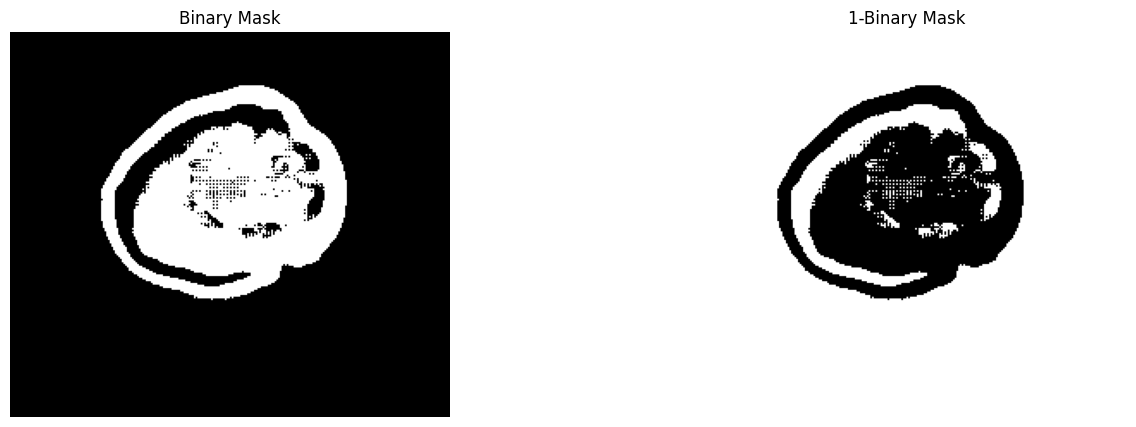

In [155]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
zs = int(mask.shape[2]/2)
ax1.imshow(binary_mask[0,0,zs,:,:], cmap='gray')
ax1.set_title('Binary Mask')
ax1.axis('off')
ax2.imshow(1-binary_mask[0,0,zs,:,:], cmap='gray')
ax2.set_title('1-Binary Mask')
ax2.axis('off')

In [156]:
model_wrapper.to(device)
noised_prediction = model_wrapper(noised_input, m)

In [157]:
noised_input = noised_input.detach().cpu()
noised_prediction = noised_prediction.detach().cpu()

In [158]:
print("PCC after noising: ", round(pearson_corr_torch(noised_prediction, pred).item(), 4))

PCC after noising:  0.9763


(-0.5, 255.5, 223.5, -0.5)

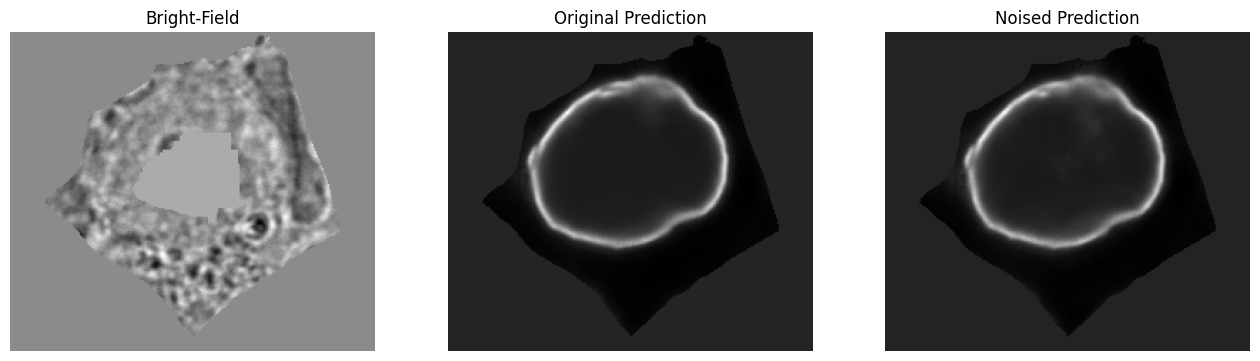

In [159]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))
zs = int(mask.shape[2]/2)
ax1.imshow(noised_input[0,0,zs,:,:], cmap='gray')
ax1.set_title('Bright-Field')
ax1.axis('off')
ax2.imshow(pred[0,0,zs,:,:], cmap='gray')
ax2.set_title('Original Prediction')
ax2.axis('off')
ax3.imshow(noised_prediction[0,0,zs,:,:], cmap='gray')
ax3.set_title('Noised Prediction')
ax3.axis('off')